
We want to figure out how many days a customer will rent a DVD for based on some features. 

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [88]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import any additional modules and start coding below
df=pd.read_csv('rental_info.csv')
print(df.head())
print("infos")
print(df.info())

                 rental_date  ... rental_rate_2
0  2005-05-25 02:54:33+00:00  ...        8.9401
1  2005-06-15 23:19:16+00:00  ...        8.9401
2  2005-07-10 04:27:45+00:00  ...        8.9401
3  2005-07-31 12:06:41+00:00  ...        8.9401
4  2005-08-19 12:30:04+00:00  ...        8.9401

[5 rows x 15 columns]
infos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13

In [89]:
import numpy as np
df["rental_length"] = pd.to_datetime(df["return_date"]) - pd.to_datetime(df["rental_date"])
df["rental_length_days"] = df["rental_length"].dt.days
print(df[["rental_date","return_date","rental_length_days"]].head())

                 rental_date                return_date  rental_length_days
0  2005-05-25 02:54:33+00:00  2005-05-28 23:40:33+00:00                   3
1  2005-06-15 23:19:16+00:00  2005-06-18 19:24:16+00:00                   2
2  2005-07-10 04:27:45+00:00  2005-07-17 10:11:45+00:00                   7
3  2005-07-31 12:06:41+00:00  2005-08-02 14:30:41+00:00                   2
4  2005-08-19 12:30:04+00:00  2005-08-23 13:35:04+00:00                   4


In [90]:
print(df['special_features'].value_counts())

{Trailers,Commentaries,"Behind the Scenes"}                     1308
{Trailers}                                                      1139
{Trailers,Commentaries}                                         1129
{Trailers,"Behind the Scenes"}                                  1122
{"Behind the Scenes"}                                           1108
{Commentaries,"Deleted Scenes","Behind the Scenes"}             1101
{Commentaries}                                                  1089
{Commentaries,"Behind the Scenes"}                              1078
{Trailers,"Deleted Scenes"}                                     1047
{"Deleted Scenes","Behind the Scenes"}                          1035
{"Deleted Scenes"}                                              1023
{Commentaries,"Deleted Scenes"}                                 1011
{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}     983
{Trailers,Commentaries,"Deleted Scenes"}                         916
{Trailers,"Deleted Scenes","Behind

In [91]:
df["deleted_scenes"] = np.where(df["special_features"].str.contains("Deleted Scenes"), 1,0)
df["behind_the_scenes"] = np.where(df["special_features"].str.contains("Behind the Scenes"), 1,0)
ct=df

In [92]:
#On a pris les informations besoin sur la duree 
cols_to_drop = ["special_features", "rental_length", "rental_length_days", "rental_date", "return_date"]
# Split into feature and target sets
X = df.drop(cols_to_drop, axis=1)
y = df["rental_length_days"]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=9)

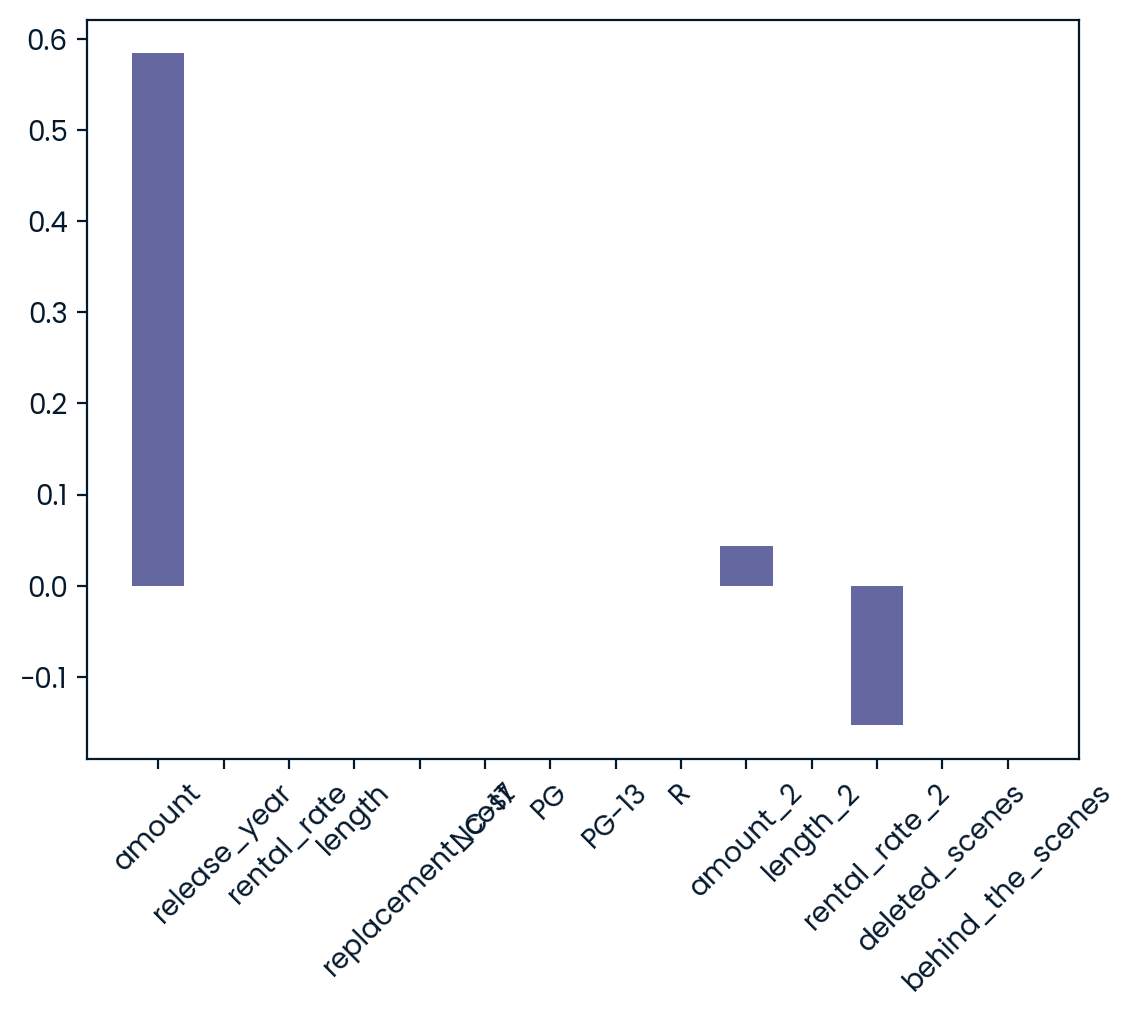

In [94]:
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
lasso = Lasso(alpha=0.3, random_state=9) 
lasso.fit(X_train,y_train)
lasso_coef = lasso.coef_
#lasso = Lasso(alpha=0.1)
#lasso_coef = lasso.fit(X_train, y_train).coef_
names = df.drop(cols_to_drop, axis=1).columns
plt.bar(names, lasso_coef)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Perform feature selection by choosing columns with positive coefficients
X_lasso_train, X_lasso_test = X_train.iloc[:, lasso_coef > 0], X_test.iloc[:, lasso_coef > 0]

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
# Linear Regression
ols = LinearRegression()
ols.fit(X_lasso_train, y_train)
y_pred_ols = ols.predict(X_lasso_test)
mse_ols = mean_squared_error(y_test, y_pred_ols)

# Decision Tree with RandomizedSearchCV
dt_param_dist = {'max_depth': np.arange(1, 21)}

dt_search = RandomizedSearchCV(DecisionTreeRegressor(), 
                               param_distributions=dt_param_dist, 
                               n_iter=20, cv=5, random_state=9)

dt_search.fit(X_train, y_train)
dt_best = dt_search.best_estimator_
y_pred_dt = dt_best.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)

# Random Forest with RandomizedSearchCV
param_dist = {'n_estimators': np.arange(1, 101),
              'max_depth': np.arange(1, 11)}

rand_search = RandomizedSearchCV(RandomForestRegressor(), 
                                 param_distributions=param_dist, 
                                 cv=5, 
                                 random_state=9)

rand_search.fit(X_train, y_train)
y_pred_rf = rand_search.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Print and compare MSEs
print(f"Linear Regression MSE: {mse_ols}")
print(f"Decision Tree MSE: {mse_dt}")
print(f"Random Forest MSE: {mse_rf}")

# Choose best model
best_model = min([("Linear Regression", mse_ols), 
                  ("Decision Tree", mse_dt), 
                  ("Random Forest", mse_rf)], key=lambda x: x[1])

print(f"The best model is {best_model[0]} with MSE: {best_model[1]}")


Linear Regression MSE: 4.812297241276244
Decision Tree MSE: 2.171257520341484
Random Forest MSE: 2.2144154507005003
The best model is Decision Tree with MSE: 2.171257520341484


In [97]:
# Choose best model
best_model=dt_best
best_mse = mse_dt

In [98]:
print(type(best_model))
print(best_mse)

<class 'sklearn.tree._classes.DecisionTreeRegressor'>
2.171257520341484
